# 5.2 Basic serving graph



In section 5.1, we showed a basic model serving function. In this section, we are going to look into the serving graph

In [1]:
import mlrun

# Set the base project name
project_name_base = 'realtime-pipelines'

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name_base, context="./", user_project=True)

# Display the current project name
project_name = project.metadata.name
print(f'Full project name: {project_name}')

> 2022-06-02 15:46:44,807 [info] loaded project realtime-pipelines from MLRun DB
Full project name: realtime-pipelines-xingsheng


## Serving Functions

To start using a serving graph, you first need a serving function. A serving function contains the serving
class code to run the model and all the code necessary to run the tasks. MLRun comes with a wide library of tasks. If you
use just those, you don't have to add any special code to the serving function, you just have to provide
the code that runs the model. For more information about serving classes see [Creating a custom model serving class](./custom-model-serving-class.md).

For example, the following code is a basic model serving class:

In [1]:
# mlrun: start-code

In [2]:
from cloudpickle import load
from typing import List
import numpy as np

import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [3]:
# mlrun: end-code

To obtain the serving function, use the `code_to_function` and specify `kind` to be `serving`.

In [23]:
fn = mlrun.code_to_function("serving_example",
                            kind="serving", 
                            image="mlrun/mlrun")

## Topology

### Router
Once you have a serving function, you need to choose the graph topology. The default is `router` topology. With the `router` topology you can specify different machine learning models. Each model has a logical name. This name is used to route to the correct model when calling the serving function.

In [24]:
model_path = "https://s3.wasabisys.com/iguazio/models/iris/model.pkl"
# model_path = project.get_artifact_uri('my_model')

In [25]:
from sklearn.datasets import load_iris

# set the topology/router
graph = fn.set_topology("router")

# Add the model
fn.add_model("model1", class_name="ClassifierModel", model_path=model_path)

# Add additional models
#fn.add_model("model2", class_name="ClassifierModel", model_path="<path2>")

# create and use the graph simulator
server = fn.to_mock_server()
x = load_iris()['data'].tolist()
result = server.test("/v2/models/model1/infer", {"inputs": x})

print(result)

> 2022-05-26 03:37:06,481 [info] model model1 was loaded
> 2022-05-26 03:37:06,481 [info] Loaded ['model1']
{'id': '6e4f1fb7bb364a3690fc87c945fd116a', 'model_name': 'model1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator AdaBoostClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


### Flow

You can use the `flow` topology to specify tasks, which typically manipulates the data. The most common scenario is pre-processing of data prior to the model execution.

```{note} Once the topology is set, you cannot change an existing function toplogy.
```

In this topology, you build and connect the graph (DAG) by adding steps using the `step.to()` method, or by using the 
`graph.add_step()` method.

> The `step.to()` is typically used to chain steps together. `graph.add_step` can add steps anywhere on the
> graph and has `before` and `after` parameters to specify the location of the step.

<!-- show example without router -->

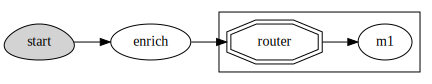

In [26]:
fn2 = mlrun.code_to_function("serving_example_flow",
                             kind="serving", 
                             image="mlrun/mlrun")

graph2 = fn2.set_topology("flow")     

graph2_enrich = graph2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')

# add an Ensemble router with two child models (routes)
router = graph2.add_step(mlrun.serving.ModelRouter(), name="router", after="enrich")
router.add_route("m1", class_name="ClassifierModel", model_path=model_path)
router.respond()

# Add additional models
# router.add_route("m2", class_name="ClassifierModel", model_path=path2)

# plot the graph (using Graphviz)
graph2.plot(rankdir='LR')

### Test the serving graph with a local mock server

In [27]:
fn2_server = fn2.to_mock_server()

result = fn2_server.test("/v2/models/m1/infer", {"inputs": x})

print(result)

> 2022-05-26 03:37:31,306 [info] model m1 was loaded
> 2022-05-26 03:37:31,307 [info] Loaded ['m1']
{'id': 'dacd7187c9cb408e8613c2408b45ce3a', 'model_name': 'm1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator AdaBoostClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
